# Getting started with Julia and Trixi.jl

[Trixi.jl](https://github.com/trixi-framework/Trixi.jl) is a numerical simulation framework for hyperbolic conservation laws written in [Julia](https://julialang.org). A key objective for the framework is to be useful to both scientists and students. Therefore, next to having an extensible design with a fast implementation, Trixi is focused on being easy to use for new or inexperienced users, including the installation and postprocessing procedures.

The primary goal of this notebook is to provide a live demonstration of Julia and Trixi during a talk given at the Numerical Analysis Seminar at Lund University in January 2021. Here, we will show how to use Trixi for setting up and running simulations, how to visualize the results, and how to extend Trixi with new functionality. The notebook and a description of how to run it with Jupyter are available at https://github.com/trixi-framework/talk-2021-julia-adaptive-multi-physics-simulations. For more information about Trixi and how to use it, please visit Trixi on [GitHub](https://github.com/trixi-framework/Trixi.jl) or refer to the [official documentation](https://trixi-framework.github.io/Trixi.jl/stable/). This notebook was set up and tested with Julia 1.5.3 but may also work with other versions.

*Note:* If you change a variable in a later cell and then re-execute an earlier cell, the results might change unexpectedly. Thus if in doubt, re-run the entire notebook *in order*. The reason is that all cells in a Jupyter notebooks share a common variable space. 

**Table of contents**
1. [Quickstart](#Quickstart)
2. [Mixing an elixir: creating a Trixi simulation from scratch](#Mixing-an-elixir:-creating-a-Trixi-simulation-from-scratch)
   1. [The basics](#The-basics)
   2. [Using a different initial condition](#Using-a-different-initial-condition)
   3. [Adaptive mesh refinement](#Adaptive-mesh-refinement)
   4. [In-situ visualization](#In-situ-visualization)
3. [Advanced usage](#Advanced-usage)
   1. [Analyzing the solution](#Analyzing-the-solution)
   2. [Running convergence tests](#Running-convergence-tests)
   3. [Visualizing the spectrum](#Visualizing-the-spectrum)
   4. [Postprocessing with Trixi2Vtk and ParaView](#Postprocessing-with-Trixi2Vtk-and-ParaView)

## Quickstart

To quickly get up and running with Trixi, load the package (only required once) and start an example 2D simulation with the following commands (to execute a Jupyter cell, select it and hit `Ctrl-Enter`):

In [ ]:
using Trixi

trixi_include(default_example())

`trixi_include(...)` is a function that loads a Julia file and executes its contents. We call such files that contain a valid Trixi setup **elixirs**. `default_example()` is part of the Trixi package and returns the path to an example elixir for running a 2D linear advection simulation.

**Please note that during the first invocation this may take a minute or two, since Julia has to compile all functions at first usage.**

The results of a Trixi simulation can easily be visualized with the [Plots](https://github.com/JuliaPlots/Plots.jl) package. Simply load `Plots` and call the `plot(...)` command with the argument `sol`. By convention, in all our elixirs `sol` (short for *solution*) is the variable name that contains the result of a simulation.

In [ ]:
using Plots

plot(sol)

## Mixing an elixir: creating a Trixi simulation from scratch

In this section, we will see how one can combine the individual components that make up Trixi into a full simulation setup that can be executed.

### The basics

Let's have a look at what an elixir looks like. Generally speaking, the following components are required:
* an **equation** object that contains all physics-specific data and functionality
* a **solver** that represents the numerical method and its algorithms
* a **mesh** that holds the grid data
* a **semidiscretization** that encapsulates equation, solver, and mesh, together with initial and boundary conditions

The semidiscretization object is then used to create an `ODEProblem` that can be solved with one of the solvers for ordinary differential equations (ODEs) from the [OrdinaryDiffEq](https://github.com/SciML/OrdinaryDiffEq.jl) package.

<div align="center">
  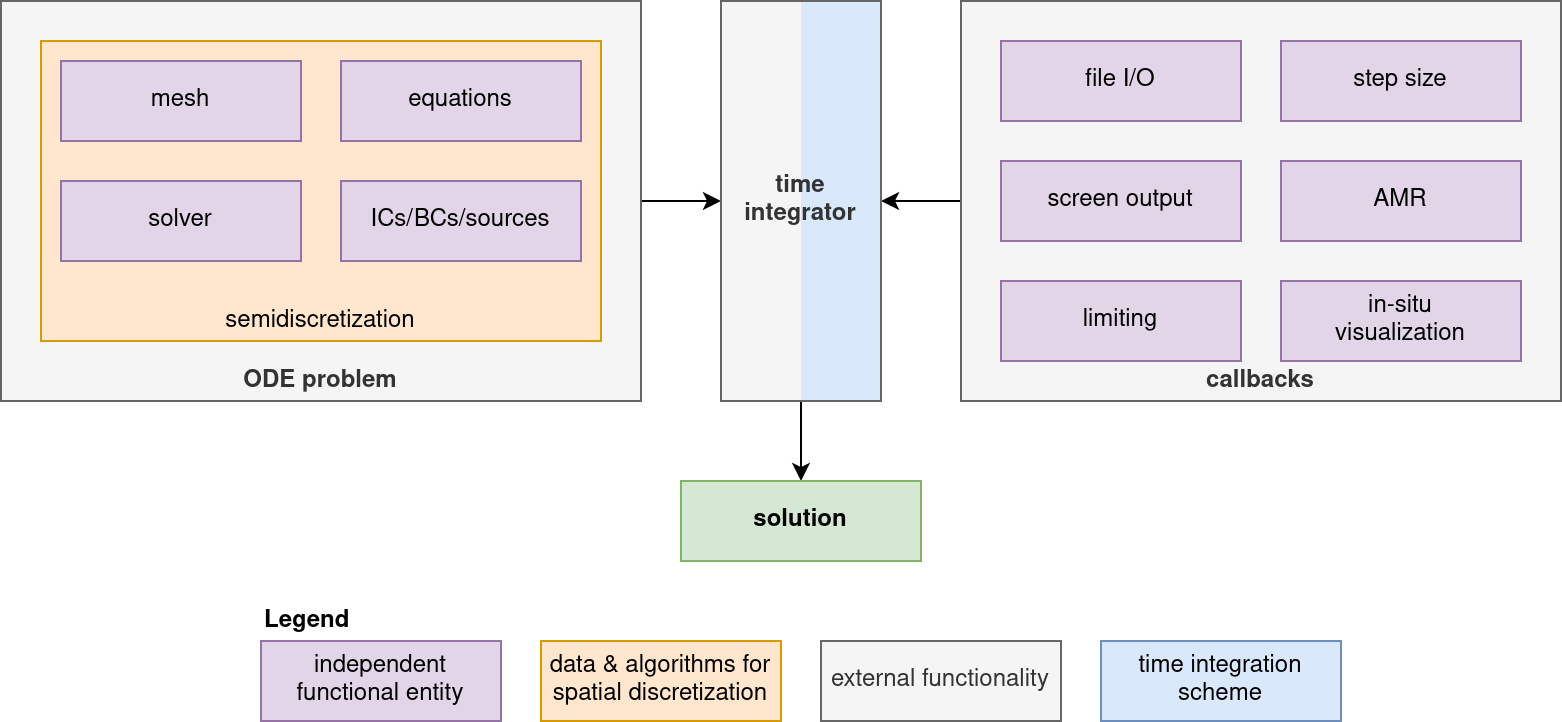
</div>

In the following are the contents of a *minimum* elixir that produces the same result as the `trixi_include(...)` command above (the elixir can be found in [examples/elixir_advection_simple.jl](examples/elixir_advection_simple.jl)):

In [ ]:
# Load necessary packages
using OrdinaryDiffEq
using Trixi

# Create equations
advectionvelocity = (1.0, 1.0)
equations = LinearScalarAdvectionEquation2D(advectionvelocity)

# Create DGSEM solver for polynomial degree = 3
solver = DGSEM(3, flux_lax_friedrichs)

# Create a uniformely refined mesh with periodic boundaries
coordinates_min = (-1, -1) # minimum coordinates
coordinates_max = ( 1,  1) # maximum coordinates
mesh_static = TreeMesh(coordinates_min, coordinates_max,
                       initial_refinement_level=4,
                       n_cells_max=30_000)

# Create semidiscretization with all spatial discretization-related components
semi = SemidiscretizationHyperbolic(mesh_static, equations,
                                    initial_condition_convergence_test,
                                    solver)

# Create ODE problem from semidiscretization with time span from 0.0 to 1.0
ode = semidiscretize(semi, (0.0, 1.0));

# Evolve ODE problem in time using OrdinaryDiffEq's `solve` method
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), dt=2.5e-2);

And that's it. In this minimum example, there is no output to the terminal/notebook, thus only the lack of errors tells us that everything went smoothly. However, as before, we can visualize the solution by plotting it with the `plot` function of the `Plots` package:

In [ ]:
using Plots

plot(sol)

As you can see from the snippet above, the entirety of a simulation setup is defined in pure Julia: There are no "special" parameter files, and changing a simulation setup means to modify its elixir. For example, we can change the advection speeds by passing a different velocity vector to `LinearScalarAdvectionEquation2D`,

```julia
# Create equations with different advection velocity
advectionvelocity = (1.0, 0.1)
equations = LinearScalarAdvectionEquation2D(advectionvelocity);
```

and re-run the simulation by re-creating the semidiscretization and the `ODEProblem`, and then calling the `solve(...)` function again.

### Using a different initial condition

So far we have only used functionality that is provided by Trixi. With its modular architecture, however, it is easy to extend Trixi with your own features. Let's define a new initial condition with a cosine-shaped pulse at its center:

In [ ]:
function cosine_pulse(x, t, equations::LinearScalarAdvectionEquation2D)
  halfwidth = 0.5
  radius = sqrt(x[1]^2 + x[2]^2)

  if radius > halfwidth
    u = 0.0
  else
    u = 0.1 + 0.1 * cos(pi * radius / halfwidth)
  end

  return Trixi.@SVector [u]
end

Now we can use this function for the initial condition parameter in the semidiscretization, re-run the simulation, and plot the results:

In [ ]:
# Recreate semidiscretization with the new initial condition
semi = SemidiscretizationHyperbolic(mesh_static, equations,
                                    cosine_pulse, # <-- here is the new initialization function
                                    solver)

# Create and solve ODE problem
ode = semidiscretize(semi, (0.0, 1.7));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), dt=2.5e-2);

# Plot result
plot(sol)

### Adaptive mesh refinement

In the previous examples, we have always used a static, uniform mesh. This means we did not fully exploit one of Trixi's fundamental building blocks: the underlying hierarchical Cartesian mesh. With its ability to locally refine the mesh in a solution-adaptive way, it can be used to greatly speed up simulations with no or minimal loss in overall accuracy. The following image series of the grid for an expanding blast wave simulation ([elixir](https://github.com/trixi-framework/Trixi.jl/blob/v0.3.7/examples/2d/elixir_euler_blast_wave_amr.jl) available with Trixi) at $t = [0.2, 0.6, 1.0]$ (left to right) illustrates how the mesh resolution is increased only where needed.

<div align="center">
  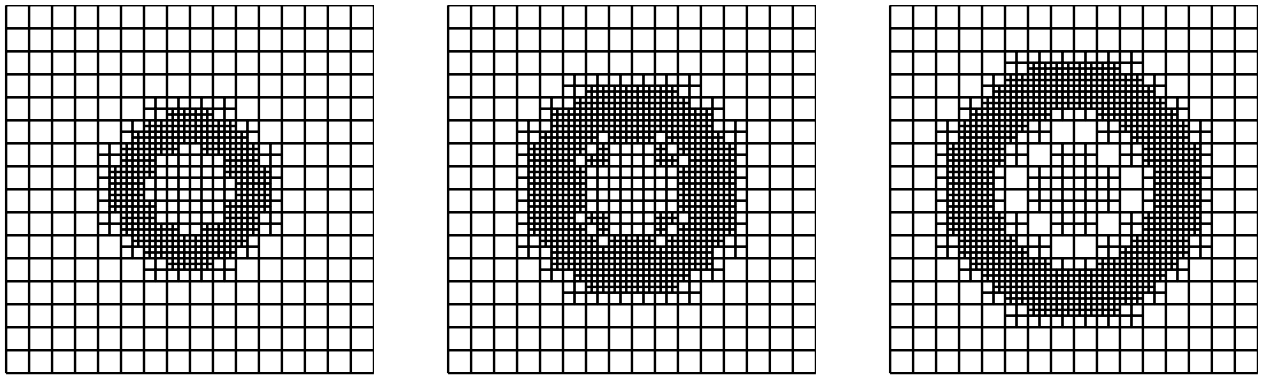
</div>

With Trixi, you can statically refine the mesh upfront, adaptively refine it during a simulation, or use a combination of both. Here, we will focus on how to do adaptive mesh refinement (AMR), which is implemented in Trixi as a **step callback**. A callback is an algorithmic entity that is registered with the ODE solver and then *called* in regular intervals to perform certain tasks: *step* callbacks are run after each time step, while *stage* callbacks are run after each stage of the ODE solver.

<div align="center">
  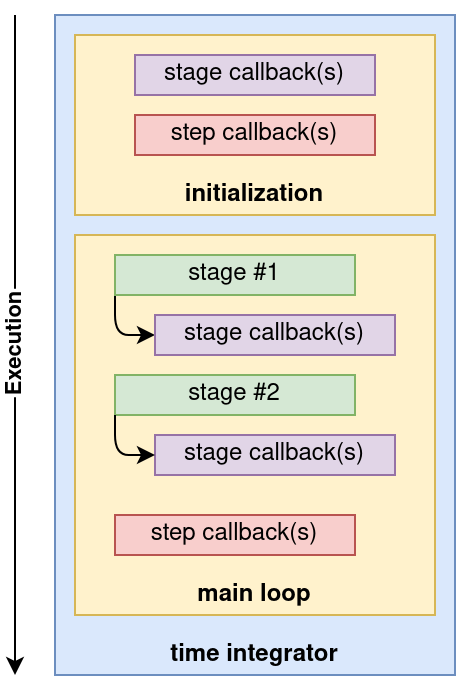
</div>

Using callbacks instead of hard-coding all features in the main loop has the advantage that it allows to extend Trixi with new functionality without having to modify its code directly. Beyond AMR, in Trixi we make use of callbacks also for tasks such as solution analysis, file I/O, in-situ visualization, or time step size calculation.

Building upon the previous example, we will now introduce the `AMRCallback` to adaptively refine the mesh around the cosine pulse every 5 steps. The callback also requires the definition of an *AMR controller*, i.e., an object that tells the AMR algorithms which cells to refine/coarsen:

In [ ]:
# Use a simple AMR controller that to refine cells between level 4 and level 6, based on the maximum value of the solution in an element
amr_controller = ControllerThreeLevel(semi,
                                      IndicatorMax(semi, variable=first),
                                      base_level=4,
                                      med_level=5, med_threshold=0.05,
                                      max_level=6, max_threshold=0.15);

# Create the AMR callback that will be called every 5 time steps
amr_callback = AMRCallback(semi, amr_controller,
                           interval=5);

The `AMRCallback` can now be passed to the ODE solver and will be invoked (i.e., performs adaptive mesh refinement) every 5 time steps. Note that we also create a new mesh with a lower initial refinement, since by default the `AMRCallback` will iteratively refine the initial mesh based on the AMR controller until it does not change anymore.

In [ ]:
# Create new mesh and semidiscretization with lower initial refinement level
mesh_amr = TreeMesh(coordinates_min, coordinates_max,
                    initial_refinement_level=2,
                    n_cells_max=30_000)
semi = SemidiscretizationHyperbolic(mesh_amr, equations,
                                    cosine_pulse,
                                    solver)

# Create and solve ODE problem, using the previously constructed AMR callback
ode = semidiscretize(semi, (0.0, 1.7));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), callback=amr_callback, dt=6.25e-3);

# Plot result
pd = PlotData2D(sol)
plot(pd, seriescolor=:heat)
plot!(getmesh(pd))

Here we also changed the color scheme and added the mesh lines to the plot to demonstrate how the mesh is locally refined around the cosine pulse. To find out more about how to visualize solutions with the `Plots` package, please refer to the [Trixi documentation](https://trixi-framework.github.io/Trixi.jl/stable/visualization/#Plots.jl).

### In-situ visualization

Another feature that is implemented in Trixi via callbacks is the ability to plot the solution during a simulation, also known as *in-situ visualization*. This can be useful to quickly check how a solution is developing over time, and is great for live demonstrations of a simulation. In its simplest form, you can create a `VisualizationCallback` only with the information in which frequency the results should be plotted, but it also allows to set formatting options:

In [ ]:
visualization_callback = VisualizationCallback(interval=50, seriescolor=:heat);

The visualization callback and the AMR callback are combined into a `CallbackSet` and then passed to the `solve` method as before:

In [ ]:
callback_set = CallbackSet(visualization_callback, amr_callback)

# Create and solve ODE problem, using the previously constructed callback set
ode = semidiscretize(semi, (0.0, 1.7));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), callback=callback_set, dt=6.25e-3);

In a simulation started from the REPL, the `VisualizationCallback` will not create seven individual images but open a single window that gets updated with each new plot as it is generated (see, e.g., this [YouTube video](https://www.youtube.com/watch?v=UZtrqeDY1Fs)). The full elixir including adaptive mesh refinement and in-situ visualization is available at [examples/elixir_advection_amr_visualization.jl](examples/elixir_advection_amr_visualization.jl).

## Advanced usage

In the following, we will introduce some of the more advanced features in Trixi (advanced in the sense that they go beyond basic functionality, not that they are particularly complicated to use).

### Analyzing the solution

Oftentimes it is desireable to analyze a running simulation quantitatively by calculating integral quantities on the fly, which can be achieved by creating an `AnalysisCallback`. By default, it computes the $L^2$ and $L^\infty$ errors and prints it to the terminal (we have seen an example of this in the [Quickstart](#Quickstart) section above). This can be extended to other built-in or user-provided integral quantities, such as the entropy time derivative $\partial S/\partial u \cdot \partial u/\partial t$, the conservation error, or the total kinetic energy.

In the following, we will create and `AnalysisCallback` that performs a solution analysis every 20 time steps, additionally computes the conservation error, and saves everything to a file (in addition to showing it on the terminal):

In [ ]:
analysis_callback = AnalysisCallback(semi,
                                     interval=20,
                                     extra_analysis_errors=(:conservation_error,),
                                     save_analysis=true);

Since the $L^2$ and $L^\infty$ errors are computed with respect to the (time-resolved) initial condition function, we will again use the  fully periodic`initial_condition_convergence_test` to initialize the solution. We will also use a static mesh again.

In [ ]:
# Create semidiscretization with a fully periodic initial condition
semi = SemidiscretizationHyperbolic(mesh_static, equations, initial_condition_convergence_test, solver)

# Create and solve ODE problem
ode = semidiscretize(semi, (0.0, 1.0));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), callback=analysis_callback, dt=2.5e-2);

Besides the errors and analysis quantities, the `AnalysisCallback` also prints out additional information on the running simulation such as the current simulation time and some performance metrics. The requested analysis data was also written to `out/analysis.dat`:

In [ ]:
print(read(joinpath("out", "analysis.dat"), String))

### Running convergence tests

When developing new numerical methods, a common part of the workflow is the check if the implemented scheme still exhibits the expected order of convergence (EOC) for mesh refinement. Trixi has a helper function `convergence_test(...)`, which re-runs a given elixir multiple times, each time increasing the mesh resolution by one. For this, we will again use the default example elixir provided by Trixi.

*Note:* Since changing the mesh resolution also affects the allowed time step through the CFL condition, `convergence_test(...)` requires the elixir to use a [StepsizeCallback](https://trixi-framework.github.io/Trixi.jl/stable/reference-trixi/#Trixi.StepsizeCallback) to automatically compute the explicit time step.

In [ ]:
# Run convergence test with default example and 3 different mesh refinement levels
convergence_test(default_example(), 3);

### Visualizing the spectrum

Trixi contains a method `linear_structure` that wraps the right-hand side operator of a semidiscretization as a linear operator. This can then be used to plot the spectrum for, e.g., the discretization of the scalar advection equation:

In [ ]:
# Include an elixir to quickly obtain an appropriate semi discretization
trixi_include(joinpath("examples", "elixir_advection_simple.jl"), initial_refinement_level=2)

# Get linear operator
A, b = linear_structure(semi)

# Compute eigenvalues
using LinearAlgebra # Contains `eigvals` to compute the eigenvalues (part of Julia)
λ = eigvals(Matrix(A))

# Plot eigenvalues in complex plane
plot(real(λ), imag(λ), seriestype=:scatter, xlims=(-40,5), ylims=(-30,30), legend=nothing)

Similarly, to analyse the spectrum of non-linear operators we can use `jacobian_fd`, which uses second-order finite differences to compute the Jacobian `J` of the operator. Here we use the elixir [examples/elixir_euler_simple.jl](examples/elixir_euler_simple.jl), which is a simplified version of an elixir for the compressible Euler equations that also comes packaged with Trixi:

In [ ]:
# Include an elixir to quickly obtain an appropriate semi discretization
trixi_include(joinpath("examples", "elixir_euler_simple.jl"))

# Determine Jacobian
J = jacobian_fd(semi)

# Compute eigenvalues
λ = eigvals(J)

# Plot eigenvalues in complex plane
plot(real(λ), imag(λ), seriestype=:scatter, xlims=(-2,2), ylims=(-1000,1000), legend=nothing)

### Postprocessing with Trixi2Vtk and ParaView

So far we have only visualized the solutions ad-hoc using the `plots(...)` function of the `Plots` package. However, for a more in-depth solution analysis especially of 3D data, it is often helpful to rely on a proper visualization program. Trixi supports converting its solution files, which are created as HDF5 files by the [SaveSolutionCallback](https://trixi-framework.github.io/Trixi.jl/stable/reference-trixi/#Trixi.SaveSolutionCallback)), to VTK files that can be opened and visualized with [ParaView](https://www.paraview.org) or [VisIt](http://visit.llnl.gov). This functionality is available in the [Trixi2Vtk](https://github.com/trixi-framework/Trixi2Vtk.jl) package, which provides a `trixi2vtk(...)` function:

In [ ]:
using Trixi2Vtk

trixi2vtk(joinpath("out", "solution_000000.h5"), output_directory="out")

This will create two files in the `out` directory, `solution_000000.vtu` and `solution_000000_celldata.vtu`. More information about how to use `trixi2vtk(...)` can be found in the [Trixi documentation](https://trixi-framework.github.io/Trixi.jl/stable/visualization/#Trixi2Vtk).